In [1]:
!pip install osmnx networkx ipywidgets matplotlib


In [2]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
from ipywidgets import Text, Button, Output, VBox

# Load walkable street network of Karachi
def load_karachi_network():
    G = ox.graph_from_place("Karachi, Pakistan", network_type='drive')
    return G



In [3]:
# Geocode place name to (latitude, longitude)
def geocode_place(place):
    try:
        location = ox.geocoder.geocode(place + ", Karachi, Pakistan")
        return location
    except:
        return None


In [4]:
def get_nearest_nodes(G, start_coords, end_coords):
    start_node = ox.distance.nearest_nodes(G, start_coords[1], start_coords[0])
    end_node = ox.distance.nearest_nodes(G, end_coords[1], end_coords[0])
    return start_node, end_node


In [5]:
def a_star_search(G, start_node, end_node):
    try:
        path = nx.astar_path(G, start_node, end_node, weight='length')
        return path
    except nx.NetworkXNoPath:
        return None


In [9]:
def visualize_path(G, path):
    # Get coordinates of nodes in the path
    node_positions = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}
    path_coords = [node_positions[node] for node in path]
    xs, ys = zip(*path_coords)

    # Calculate bounding box to zoom in
    buffer = 0.005  # degrees of lat/lon, adjust for zoom
    min_x, max_x = min(xs) - buffer, max(xs) + buffer
    min_y, max_y = min(ys) - buffer, max(ys) + buffer

    # Set up figure
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.set_facecolor("black")
    ax.set_title("Zoomed A* Route in Karachi", fontsize=18, fontweight='bold', color='darkblue')

    # Plot full graph (but only show the zoomed-in window)
    ox.plot_graph(G, node_size=0, edge_color='white', show=False, close=False, ax=ax)

    # Plot route
    ax.plot(xs, ys, color='dodgerblue', linewidth=4, alpha=0.8, label="Shortest Path")

    # Direction arrows
    for i in range(len(xs) - 1):
        ax.annotate(
            '', xy=(xs[i+1], ys[i+1]), xytext=(xs[i], ys[i]),
            arrowprops=dict(arrowstyle='->', color='blue', lw=1.5)
        )

    # Start and End markers
    ax.plot(xs[0], ys[0], marker='o', color='green', markersize=10, label='Start')
    ax.plot(xs[-1], ys[-1], marker='X', color='red', markersize=10, label='End')

    # Zoom limits (bounding box)
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)

    ax.legend(loc='upper right', fontsize='large')
    plt.axis('off')
    plt.show()


In [13]:
# Main interactive app
def run_app():
    G = load_karachi_network()

    start_text = Text(value=" ", description="From:")
    end_text = Text(value=" ", description="To:")
    button = Button(description="Find Route", button_style='success')
    output = Output()

    def on_click(b):
        with output:
            output.clear_output()
            start_place = start_text.value
            end_place = end_text.value

            start_coords = geocode_place(start_place)
            end_coords = geocode_place(end_place)

            if not start_coords or not end_coords:
                print("❌ Error: Couldn't find one or both locations.")
                return

            start_node, end_node = get_nearest_nodes(G, start_coords, end_coords)
            path = a_star_search(G, start_node, end_node)

            if path:
                print(f"✅ Path found between {start_place} and {end_place}. Visualizing...")
                visualize_path(G, path)
            else:
                print("❌ No path found between these two locations.")

    button.on_click(on_click)
    display(VBox([start_text, end_text, button, output]))


✅ Path found between Hyderi and Lucky One Mall. Visualizing...


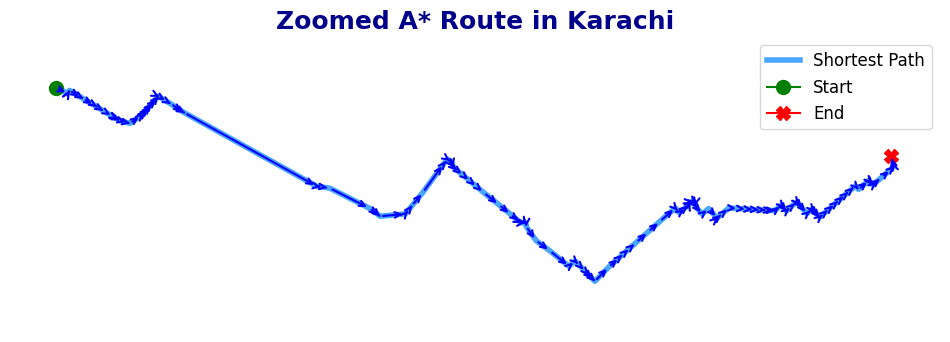

In [12]:
# Run the interactive app
run_app()